In [ ]:
import json
import yaml
import pandas as pd
import wandb
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats

import imprl.structural_envs as structural_envs
from imprl.post_process.inference import AgentInference
from imprl.post_process.inference import HeuristicInference
from imprl.baselines.TPI_CBM import TimePeriodicInspectionConditionBasedMaintenance as TPI_CBM

In [2]:
ENV_NAME = 'k_out_of_n'
SETTINGS = [f'hard-{i+1}-of-5' for i in range(5)]
ALGORITHMS = ['JAC', 'DCMAC', 'DDMAC', 'IACC', 'IACC_PS', 'IAC', 'IAC_PS']
ALGORITHM_LABELS = ['JAC', 'DCMAC', 'DDMAC', 'IACC', 'IACC-PS', 'IAC', 'IAC-PS']

NUM_TASKS = len(SETTINGS)
NUM_ALGORITHMS = len(ALGORITHMS)
NUM_EPISODES = 100_000
NUM_SEEDS = 10

inference_frequency = 4_000
INFERENCE_EPISODES = []
for ep in range(NUM_EPISODES):
    if ep % inference_frequency == 0 or ep == NUM_EPISODES - 1:
        INFERENCE_EPISODES.append(ep)

path_prefix = './model_checkpoints'

with open(f'{path_prefix}/run_ids_10.yaml') as f:
    store_runs_ids = yaml.load(f, Loader=yaml.FullLoader)

### Best performance

In [3]:
# store best inference cost and std err for every run
# shape: (NUM_TASKS, len(ALGORITHMS), NUM_SEEDS, len(INFERENCE_EPISODES), len[(]mean, std_err]))
store_inference_cost = np.ones((NUM_TASKS, len(ALGORITHMS), NUM_SEEDS, len(INFERENCE_EPISODES), 2)) * -1

_dict = {}
results = []

for s, setting in enumerate(SETTINGS):
    _dict = {'setting': setting}
    for a, alg in enumerate(ALGORITHMS):
        _dict['alg'] = alg
        for r in range(NUM_SEEDS):
            run_id = store_runs_ids[ENV_NAME][setting][alg][r]
            _dict['run_id'] = run_id

            # get inference results
            with open(f'{path_prefix}/{ENV_NAME}/{setting}/{alg}/runs/{run_id}/inference_log.json') as f:
                inference_log = json.load(f)

                for i, ep in enumerate(INFERENCE_EPISODES):
                    store_inference_cost[s, a, r, i, 0] = inference_log[f'chkpt_{ep}']['mean']

                    _values = inference_log[f'chkpt_{ep}']['values']
                    # compute std err
                    _std_err = stats.sem(_values)
                    store_inference_cost[s, a, r, i, 1] = _std_err

                    _dict['inference_ep'] = ep
                    _dict['inference_mean'] = store_inference_cost[s, a, r, i, 0]
                    _dict['inference_std_err'] = store_inference_cost[s, a, r, i, 1]

                    results.append(_dict.copy())  # append a copy of _dict to the results list

# check that no values are -1
assert np.all(store_inference_cost != -1)

# Convert the list of dictionaries to a DataFrame
df_results = pd.DataFrame(results) 

In [4]:
df_results

,setting,alg,run_id,inference_ep,inference_mean,inference_std_err
0,hard-1-of-5,JAC,eewzhajn,0,13649.433526,10.607231
1,hard-1-of-5,JAC,eewzhajn,4000,4284.761565,5.746897
2,hard-1-of-5,JAC,eewzhajn,8000,3875.805757,7.717279
3,hard-1-of-5,JAC,eewzhajn,12000,3163.737482,21.161665
4,hard-1-of-5,JAC,eewzhajn,16000,1453.320882,7.792570
...,...,...,...,...,...,...
9095,hard-5-of-5,IAC_PS,dkpy1vfi,84000,14066.332679,36.563001
9096,hard-5-of-5,IAC_PS,dkpy1vfi,88000,14225.077816,37.282048
9097,hard-5-of-5,IAC_PS,dkpy1vfi,92000,14051.037027,36.312188
9098,hard-5-of-5,IAC_PS,dkpy1vfi,96000,14311.933990,33.610763


# Plot

## Learning curves

/var/folders/w7/40d8p5l1307f8nrkqgv9q47xhwh1n2/T/ipykernel_45274/1636719031.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot_dict = ax.boxplot(y, whis=0.0,
/var/folders/w7/40d8p5l1307f8nrkqgv9q47xhwh1n2/T/ipykernel_45274/1636719031.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot_dict = ax.boxplot(y, whis=0.0,
/var/folders/w7/40d8p5l1307f8nrkqgv9q47xhwh1n2/T/ipykernel_45274/1636719031.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  boxplot_dict = ax.boxplot(y, whis=0.0,
/var/folders/w7/40d8p5l1307f8nrkqgv9q47xhwh1n2/T/ipykernel_45274/1636719031.py:105: MatplotlibDeprecationWarning: The 

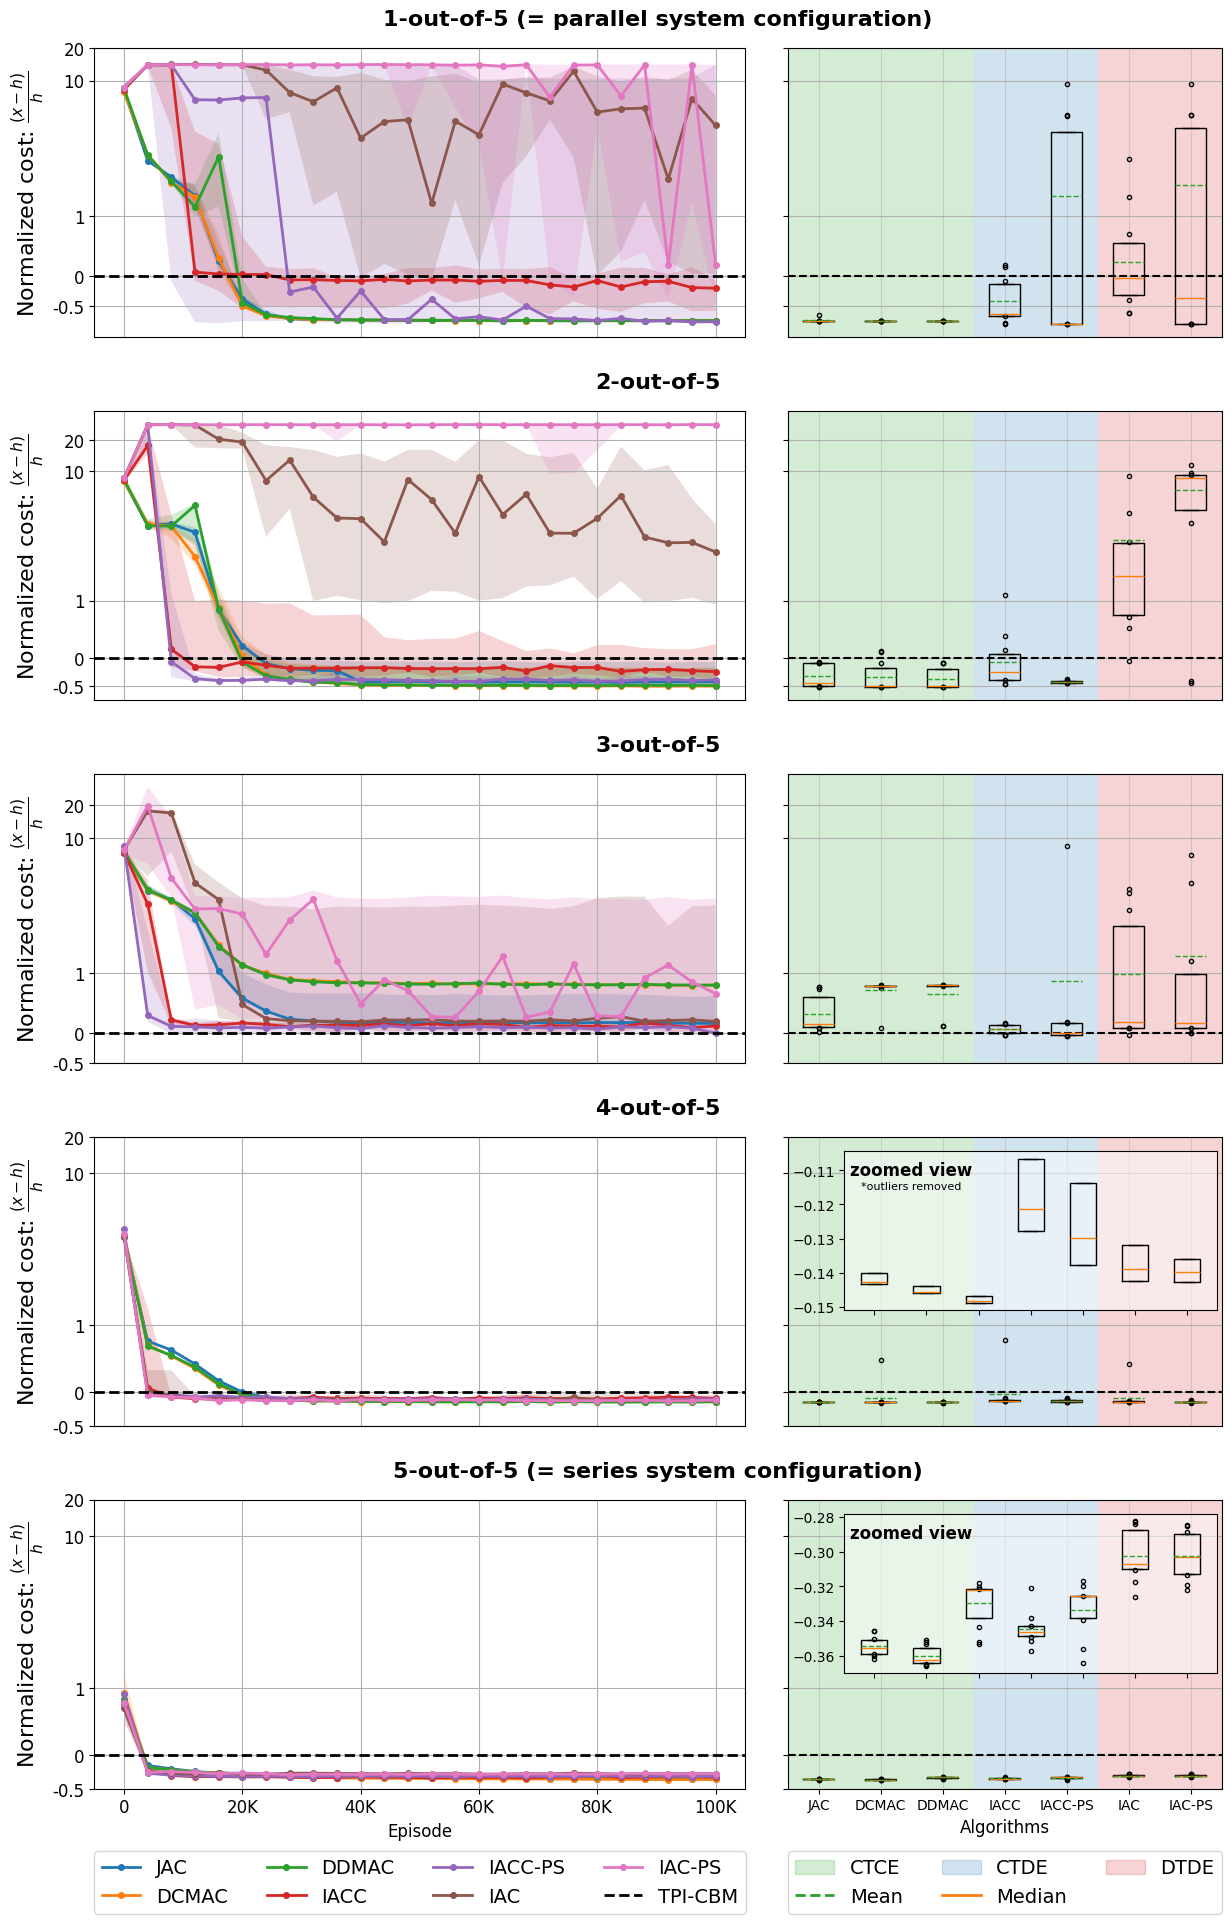

In [5]:
mosaic = """
         05
         16
         27
         38
         49
         """

fig, axs = plt.subplots(5, 2, figsize=(12, 18), width_ratios=[1.5, 1])
fig.tight_layout(h_pad=3.2, w_pad=0.0)
from matplotlib import ticker

############################ TRAINING CURVES ###########################

for i, setting in enumerate(SETTINGS):

    ax = axs[i][0]

    ax.sharey(axs[i][1])

    env = structural_envs.make(setting=setting)
    baseline = env.baselines['TPI-CBM']['mean']

    # shape: (NUM_TASKS, len(ALGORITHMS), NUM_SEEDS, len(INFERENCE_EPISODES))
    y = store_inference_cost[i, :, :, :, 0]

    y = (y - baseline) / baseline

    # mean = np.mean(y, axis=1)
    median = np.median(y, axis=1)

    ax.plot(INFERENCE_EPISODES, median.T, '-o', 
            markersize=4,
            linewidth=2, 
            label=ALGORITHM_LABELS)
    
    # plot IQR
    for a, alg in enumerate(ALGORITHMS):
        upper = np.percentile(y[a, :, :], 75, axis=0)
        lower = np.percentile(y[a, :, :], 25, axis=0)
        ax.fill_between(INFERENCE_EPISODES, lower, upper, alpha=0.2)
        
    # baselines
    ax.axhline(y=0.0, color='k', linestyle='--', linewidth=2, label='TPI-CBM')

    ax.set_xticks([x*1000 for x in range(0, 120, 20)])
    ax.set_yticks([-0.5, 0, 1, 10, 20])
    ax.set_yticklabels(['-0.5', '0', '1', '10', '20'], fontsize=12)
    ax.set_ylabel(r'Normalized cost: $\frac{(x-h)}{h}$', fontsize=16)
    ax.set_yscale('symlog')
    ax.grid(True)

    # hide x ticks
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax.tick_params(axis='x', which='both', bottom=True, labelbottom=True)
ax.set_xticklabels(['0', '20K', '40K', '60K', '80K', '100K'], fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlabel('Episode', fontsize=12)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=4, fontsize=14)

verbose = False

############################## BOX PLOTS ##############################

for i, setting in enumerate(SETTINGS):

    ax = axs[i][1]
    ax.sharey(axs[i][1])

    if i == 0:
        ax.text(-0.3, 1.1, f"{i+1}-out-of-5 (= parallel system configuration)", fontsize=16, fontweight='bold', 
                ha='center', va='center', transform=ax.transAxes)
        
        # add dagger to indicate the IAC policy for which we do policy rollout
        # ax.text(0.81, 0.6, r"$\dag$", fontsize=16, color='blue',
        #         ha='center', va='center', transform=ax.transAxes)

    elif i == 4:
        ax.text(-0.3, 1.1, f"{i+1}-out-of-5 (= series system configuration)", fontsize=16, fontweight='bold', 
                ha='center', va='center', transform=ax.transAxes)
    else:
        ax.text(-0.3, 1.1, f"{i+1}-out-of-5", fontsize=16, fontweight='bold', 
        ha='center', va='center', transform=ax.transAxes)


    env = structural_envs.make(setting=setting)

    tpi_cbm_baseline = env.baselines['TPI-CBM']['mean']
    fr_baseline = env.baselines['FailureReplace']['mean']

    # ax.hlines(fr_baseline, 1, 7, colors='tab:red', linestyles='dashed', label='FailureReplace')
    # ax.hlines(tpi_cbm_baseline, 0.5, 7.5, colors='black', linestyles='dashed', label='TPI-CBM (heuristic)')
    ax.hlines(0, 0.5, 7.5, colors='black', linestyles='dashed', label='TPI-CBM (heuristic)')
    # draw shaded regions around the baselines
    # ax.fill_between([0.5, 7.5], 0.9, 1.1, color='tab:red', alpha=0.2)

    y = store_inference_cost[i, :, :, :, 0].min(axis=2).T

    # normalize by baseline
    y = (y - tpi_cbm_baseline) / tpi_cbm_baseline
    # y = (y /tpi_cbm_baseline)
    
    boxplot_dict = ax.boxplot(y, whis=0.0,
                              labels=ALGORITHM_LABELS, manage_ticks=True, 
                              showfliers=True,
                              meanline=True, showmeans=True, 
                              medianprops={"color":'tab:orange'}, 
                              meanprops={'color':'tab:green'},
                              flierprops={'marker':'o', 'markersize':3, 'color':'tab:blue'})

    ax.grid(axis='x', alpha=0.5)
    # ax.set_yscale('log')
    ax.set_yscale('symlog')
    # hide y ticks
    ax.tick_params(axis='y', which='both', labelleft=False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.set_yticks([-0.5, 0, 1, 10, 20])
    ax.set_yticklabels(['-0.5', '0', '1', '10', '20'], fontsize=12)

    # highlight paradigms
    ax.axvspan(0.5, 3.5, facecolor='tab:green', alpha=0.2) # CTCE
    ax.axvspan(3.5, 5.5, facecolor='tab:blue', alpha=0.2) # CTDE
    ax.axvspan(5.5, 7.5, facecolor='tab:red', alpha=0.2) # DTDE

    ax.grid(axis='y')

    # create inset axes for 4-of-5 and 5-of-5 settings
    if i == 4 or i == 3:
        x1, x2, y1, y2 = 0.6, 7.5, -0.3, 1
        ax_inset = ax.inset_axes([0.13, 0.4, 0.86, 0.55],
                                #   xlim=(x1, x2), ylim=(y1, y2),
                                  xticklabels=[], yticklabels=[])
        # format inset axes
        if i == 3:
            ax_inset.boxplot(y, whis=0.0,
                manage_ticks=False,
                showfliers=False,
                # meanline=True, showmeans=True, 
                medianprops={"color":'tab:orange'}, 
                meanprops={'color':'tab:green'},
                flierprops={'marker':'o', 'markersize':3, 'color':'tab:blue'})
            
            ax_inset.text(0.18, 0.78, f"*outliers removed", 
                        fontsize=8, ha='center',
                        va='center', transform=ax_inset.transAxes)
        elif i == 4:
            ax_inset.boxplot(y, whis=0.0,
                            manage_ticks=False,
                            showfliers=True,
                            meanline=True, showmeans=True, 
                            medianprops={"color":'tab:orange'}, 
                            meanprops={'color':'tab:green'},
                            flierprops={'marker':'o', 'markersize':3, 'color':'tab:blue'})
            
            ax_inset.set_yticks([-0.36, -0.34, -0.32, -0.3, -0.28])
            ax_inset.set_yticklabels(['-0.36', '-0.34', '-0.32', '-0.3', '-0.28'], fontsize=10)

        ax_inset.text(0.18, 0.88, f"zoomed view", 
                      fontsize=12, ha='center', fontweight='bold',
                      va='center', transform=ax_inset.transAxes)

        ax_inset.tick_params(axis='y', bottom=False, top=False, 
                             labelbottom=False, left=True, right=False, 
                             labelleft=True)
        ax_inset.set_yscale("linear")
        ax_inset.patch.set_alpha(0.5)
        ax_inset.grid(False)

ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labelsize=10)
ax.set_xlabel('Algorithms', fontsize=12)

# customize legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Add custom legend items
mean_legend_item = Line2D([0], [0], color='tab:green', linewidth=2, linestyle='--', label='Mean')
median_legend_item = Line2D([0], [0], color='tab:orange', linewidth=2, linestyle='-', label='Median')
ctce_legend_item = Patch(color='tab:green', alpha=0.2, label='CTCE')
ctde_legend_item = Patch(color='tab:blue', alpha=0.2, label='CTDE')
dtde_legend_item = Patch(color='tab:red', alpha=0.2, label='DTDE')

handles, labels = [], []
handles.extend([ctce_legend_item, mean_legend_item, ctde_legend_item, median_legend_item, dtde_legend_item])
labels.extend(['CTCE', 'Mean', 'CTDE', 'Median', 'DTDE'])

all_handles = handles 

# axbox = ax_dict['settings'].get_position()
ax.legend(handles=all_handles, 
          bbox_to_anchor=[0.4, -.38, 0.2, 0.2], 
          loc="upper center", 
          ncol=3, 
          reverse=False,
          prop={'size': 14})

# plt.savefig(f"./box_and_learning.pdf", bbox_inches='tight', dpi=500, transparent=False)
# plt.savefig(f"./box_and_learning.svg", bbox_inches='tight', dpi=500, transparent=True)

plt.show()

# Tables

### Best performance

In [6]:
# best performance across all random seeds 
_best = np.empty((NUM_TASKS, NUM_ALGORITHMS))
best_conf_ints = np.empty((NUM_TASKS, NUM_ALGORITHMS))

df_best = pd.DataFrame(columns=SETTINGS)

# add heuristic baseline
for s, setting in enumerate(SETTINGS):
    env = structural_envs.make(setting=setting)
    tpi_cbm_mean = env.baselines['TPI-CBM']['mean']
    tpi_cbm_conf_int = 1.96 * env.baselines['TPI-CBM']['stderr']
    fr_mean = env.baselines['FailureReplace']['mean']
    fr_conf_int = 1.96 * env.baselines['FailureReplace']['stderr']
    df_best.loc['TPI-CBM', setting] = f"{tpi_cbm_mean} (±{tpi_cbm_conf_int :.2f})"
    # df_best.loc['FailureReplace', setting] = f"{fr_mean} (±{fr_conf_int :.2f})"

for s, setting in enumerate(SETTINGS):
    for a, alg in enumerate(ALGORITHMS):
        
        _y = df_results[(df_results['setting'] == setting) & (df_results['alg'] == alg)]

        # best seed
        _best[s, a] = _y['inference_mean'].min()

        # std err of best seed
        _std_err = _y[_y['inference_mean'] == _best[s, a]]['inference_std_err'].values[0]

        best_conf_ints[s, a] = 1.96 * _std_err

        # add to dataframe
        df_best.loc[alg, setting] = f'{_best[s, a]:.2f} (±{best_conf_ints[s, a] :.2f})'

# save to csv
# df_best.to_csv(f'./best_performance_15.csv')

display(df_best)

,hard-1-of-5,hard-2-of-5,hard-3-of-5,hard-4-of-5,hard-5-of-5
TPI-CBM,1485.74 (±8.43),1498.8 (±8.62),1654.19 (±14.11),3998.41 (±43.51),19728.42 (±95.45)
JAC,365.51 (±10.90),735.96 (±13.59),1686.41 (±18.56),3413.96 (±33.88),12595.17 (±67.70)
DCMAC,363.64 (±10.96),735.56 (±14.08),1789.00 (±21.25),3396.92 (±32.64),12509.88 (±66.73)
DDMAC,364.10 (±10.67),732.62 (±13.49),1858.60 (±24.16),3384.11 (±32.95),12764.02 (±67.13)
IACC,298.01 (±7.96),820.21 (±13.80),1600.01 (±15.00),3460.20 (±35.57),12685.70 (±66.53)
IACC_PS,285.64 (±7.99),833.55 (±10.28),1578.24 (±14.88),3421.71 (±35.39),12543.43 (±69.51)
IAC,563.99 (±21.91),1422.94 (±18.13),1603.05 (±14.76),3421.37 (±32.43),13291.65 (±73.41)
IAC_PS,296.57 (±8.42),850.90 (±16.11),1646.18 (±14.46),3395.78 (±34.13),13370.26 (±76.00)


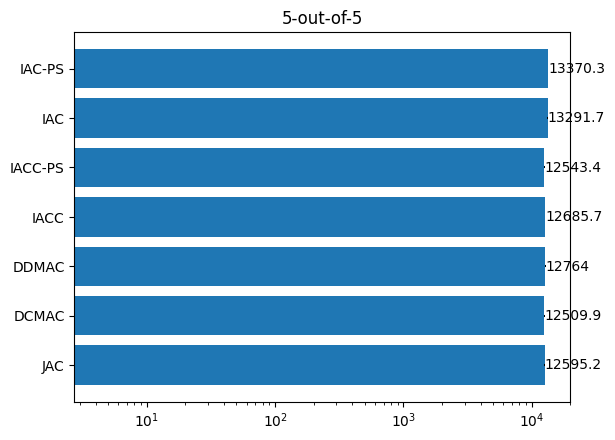

In [7]:
fig, ax = plt.subplots()
s = 4
bars = ax.barh(ALGORITHM_LABELS, _best[s, :], xerr=best_conf_ints[s, :], log=True)

ax.bar_label(bars)
ax.set_title(f'{s+1}-out-of-5')
plt.show()

### Mean performance

In [8]:
data_tables = store_inference_cost[:, :, :, :, 0].min(-1) # shape: (tasks, algorithms, seeds)

_means = np.empty((NUM_TASKS, NUM_ALGORITHMS))
mean_conf_ints = np.empty((NUM_TASKS, NUM_ALGORITHMS))

# create dataframe with columns: SETTINGS
df_means = pd.DataFrame(columns=SETTINGS)

# Format the mean and confidence interval as a string
def _format_mean_ci(mean, ci):
    return f'{mean:.2f} (±{ci[1]-ci[0]:.2f})'

# add heuristic baseline
for s, setting in enumerate(SETTINGS):
    env = structural_envs.make(setting=setting)
    df_means.loc['TPI-CBM', setting] = env.baselines['TPI-CBM']['mean']

# compute confidence intervals
_conf_ints = np.empty((NUM_TASKS, NUM_ALGORITHMS))
for a, alg in enumerate(ALGORITHM_LABELS):
    for s, setting in enumerate(SETTINGS):

        _means[s, a] = np.mean(data_tables[s, a, :])

        _std_errs = scipy.stats.sem(data_tables[s, a, :])
        mean_conf_ints[s, a] = 1.96 * _std_errs

        # _cis[s, a, :] = stats.norm.interval(0.95, loc=_means[s, a], scale=stats.sem(data_tables[s, a, :]))

        # add to dataframe
        # df_means.loc[alg, setting] = _format_mean_ci(_means[s, a], _cis[s, a, :])
        df_means.loc[alg, setting] = f'{_means[s, a]:.2f} (±{mean_conf_ints[s, a] :.2f})'


# save to csv
# df_means.to_csv(f'./mean_performance_15.csv')

df_means

,hard-1-of-5,hard-2-of-5,hard-3-of-5,hard-4-of-5,hard-5-of-5
TPI-CBM,1485.74,1498.8,1654.19,3998.41,19728.42
JAC,384.13 (±31.49),1024.11 (±190.13),2171.23 (±325.35),3430.42 (±5.67),12734.10 (±70.61)
DCMAC,368.41 (±1.89),992.42 (±251.81),2836.87 (±228.63),3664.83 (±487.65),12624.09 (±70.22)
DDMAC,367.86 (±2.31),936.81 (±185.22),2748.93 (±290.40),3404.17 (±7.07),13223.15 (±169.18)
IACC,855.47 (±350.30),1391.91 (±455.24),1770.00 (±78.32),3882.37 (±706.66),12935.37 (±118.50)
IACC-PS,3456.83 (±3360.61),874.66 (±23.33),3105.45 (±2716.64),3505.62 (±50.52),13152.28 (±192.38)
IAC,1823.51 (±778.28),4764.07 (±2450.31),3299.18 (±1384.54),3668.82 (±434.44),13760.73 (±185.89)
IAC-PS,3732.06 (±3268.25),11346.33 (±3938.87),3777.89 (±2385.82),3445.91 (±21.78),13760.14 (±178.94)


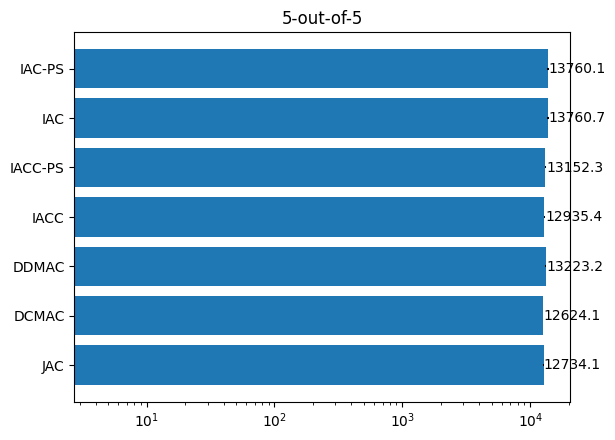

In [9]:
fig, ax = plt.subplots()
s = 4
bars = ax.barh(ALGORITHM_LABELS, _means[s, :], xerr=mean_conf_ints[s, :], log=True)

ax.bar_label(bars)
ax.set_title(f'{s+1}-out-of-5')

plt.show()

# Aggregate Performance

In [10]:
from rliable import library as rly
from rliable import metrics

In [11]:
# heuristic 
best_heuristic = np.empty(5)
for i in range(5):
    env = structural_envs.make(setting=f'hard-{i+1}-of-5')
    best_heuristic[i] = env.baselines['TPI-CBM']['mean']

print(f'Best heuristic: {best_heuristic}')

# normalize by heuristic
score_dict = {} # shape: (algs, seeds, tasks)
for a, alg in enumerate(ALGORITHMS):
    temp = store_inference_cost[:, a, :, :, 0].min(axis=2).T
    score_dict[alg] = temp/best_heuristic - 1

Best heuristic: [ 1485.74  1498.8   1654.19  3998.41 19728.42]


In [12]:
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate, aggregate_cis = rly.get_interval_estimates(
  score_dict, aggregate_func, reps=50_000)

### Plot

In [13]:
from rliable.plot_utils import _decorate_axis

def plot_interval_estimates(point_estimates,
                            interval_estimates,
                            metric_names,
                            algorithms=None,
                            max_ticks=4,
                            row_height=0.37,
                            xlabel=None,
                            fig=None,
                            axes=None,
                            set_title=True,
                            colors=None,
                            algorithm_labels=None,
                            **kwargs):
  """Plots various metrics with confidence intervals.

  Args:
    point_estimates: Dictionary mapping algorithm to a list or array of point
      estimates of the metrics to plot.
    interval_estimates: Dictionary mapping algorithms to interval estimates
      corresponding to the `point_estimates`. Typically, consists of stratified
      bootstrap CIs.
    metric_names: Names of the metrics corresponding to `point_estimates`.
    algorithms: List of methods used for plotting. If None, defaults to all the
      keys in `point_estimates`.
    colors: Maps each method to a color. If None, then this mapping is created
      based on `color_palette`.
    color_palette: `seaborn.color_palette` object for mapping each method to a
      color.
    max_ticks: Find nice tick locations with no more than `max_ticks`. Passed to
      `plt.MaxNLocator`.
    subfigure_width: Width of each subfigure.
    row_height: Height of each row in a subfigure.
    xlabel_y_coordinate: y-coordinate of the x-axis label.
    xlabel: Label for the x-axis.
    **kwargs: Arbitrary keyword arguments.

  Returns:
    fig: A matplotlib Figure.
    axes: `axes.Axes` or array of Axes.
  """

  if algorithms is None:
    algorithms = list(point_estimates.keys())
  num_metrics = len(point_estimates[algorithms[0]])

  h = kwargs.pop('interval_height', 0.4)

  for idx, metric_name in enumerate(metric_names):
    for alg_idx, algorithm in enumerate(algorithms):
      ax = axes[idx] if num_metrics > 1 else axes
      # Plot interval estimates.
      lower, upper = interval_estimates[algorithm][:, idx]
      ax.barh(
          y=alg_idx,
          width=upper - lower,
          height=h,
          left=lower,
          alpha=0.75,
          color=colors[algorithm],
          label=algorithm)
      # Plot point estimates.
      ax.vlines(
          x=point_estimates[algorithm][idx],
          ymin=alg_idx - (7.5 * h / 16),
          ymax=alg_idx + (6 * h / 16),
          label=algorithm,
          color='k',
          alpha=0.5)

    ax.set_yticks(list(range(len(algorithms))))
    ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
    if idx != 0:
      ax.set_yticks([])
    else:
      ax.set_yticklabels(algorithm_labels, fontsize=2)
    if set_title:
      ax.set_title(metric_name)
    ax.tick_params(axis='both', which='major')
    _decorate_axis(ax, wrect=1)
    ax.spines['left'].set_visible(False)
    ax.grid(True, axis='x', alpha=0.25)
  return fig, axes

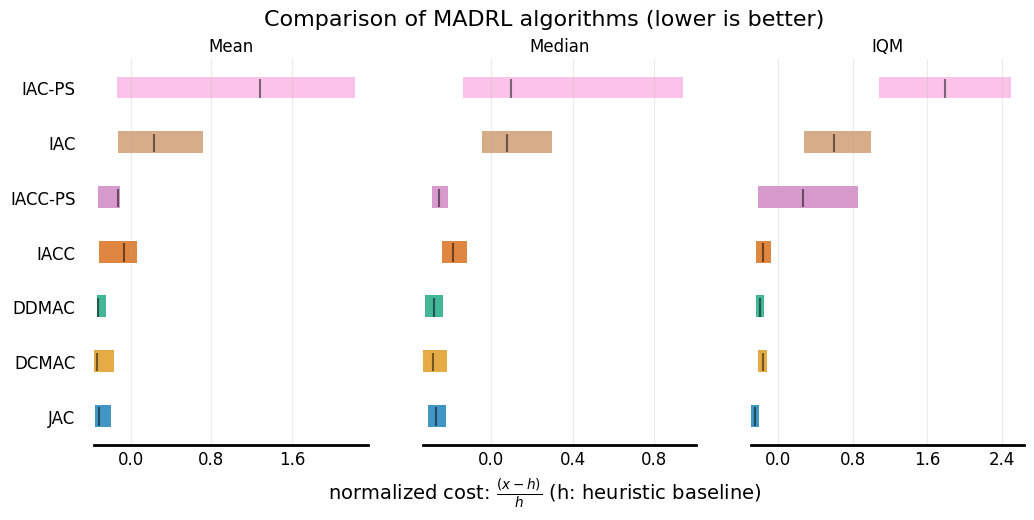

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
color_palette = sns.color_palette('colorblind', n_colors=len(ALGORITHMS))

colors = dict(zip(ALGORITHMS, color_palette))
plot_interval_estimates(
  aggregate, aggregate_cis,
  metric_names=['Mean', 'Median', 'IQM'],
  algorithms=ALGORITHMS, xlabel=None, axes=ax, fig=fig,
  algorithm_labels = ALGORITHM_LABELS,
  colors=colors)

fig.text(0.5, 0, r'normalized cost: $\frac{(x-h)}{h}$ (h: heuristic baseline)', ha='center', fontsize=14)

fig.suptitle('Comparison of MADRL algorithms (lower is better)', fontsize=16)
# fig.tight_layout()

# plt.savefig(f"./aggregate.pdf", bbox_inches='tight', dpi=300)

plt.show()

# Policy Realisations for analysis

In [15]:
from imprl.post_process.inference import AgentInference
from imprl.post_process.inference import HeuristicInference
from imprl.runners.parallel import parallel_agent_rollout
from imprl.agents.FR import FailureReplace as FR

## Helper functions

In [16]:
def get_run_cost(run_id, path_prefix, sort_by='best_mean_cost'):
    
    with open(f'{path_prefix}/{run_id}/inference_log.json') as f:
        data = json.load(f)
        return data[sort_by]
    
def get_sorted_run_ids(run_ids, path_prefix, sort_by='best_mean_cost'):
    sorted_run_ids = sorted(run_ids, key=lambda run_id: get_run_cost(run_id, path_prefix, sort_by))
    return sorted_run_ids

def get_agent(env, alg, path_prefix, run_id):

    with open(f'{path_prefix}/{run_id}/inference_log.json') as f:
        data = json.load(f)
        best_checkpt = data['best_checkpoint']

    weights_path = f"{path_prefix}/{run_id}/model_weights"
    agent = AgentInference(alg, env)
    agent.load_weights(weights_path, best_checkpt)

    _run_cost = get_run_cost(run_id, path_prefix)
    print(f'Run ID: {run_id}, Run Cost: {_run_cost}')

    return agent

def get_best_agent(env, env_setting, alg, path_prefix):

    run_ids = store_runs_ids[ENV_NAME][env_setting][alg]

    best_run_id = get_sorted_run_ids(run_ids, path_prefix)[0]

    return get_agent(env, alg, path_prefix, best_run_id)

### Best agent performance

Loaded default configuration for IACC_PS.
Run ID: ca4njjgm, Run Cost: 1578.2374830760666


/Users/pbhustali/Documents/GitHub/optimality-of-decentralization/imprl-public/src/imprl/post_process/plotter/agent_plotter.py:185: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


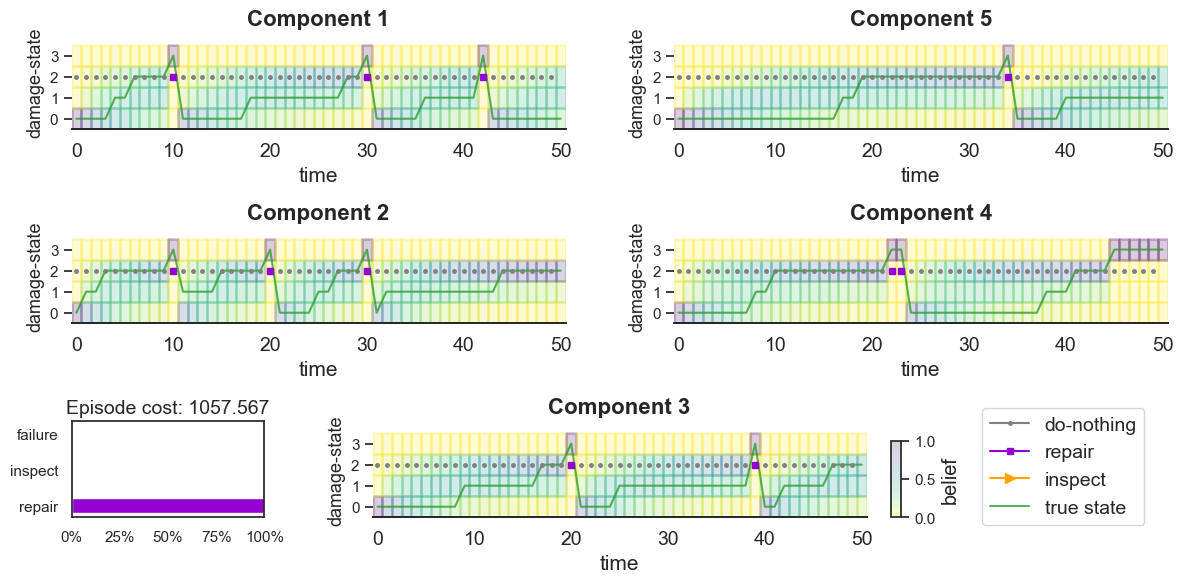

In [17]:
env_setting = 'hard-3-of-5'
env = structural_envs.make(setting=env_setting)

ALGORITHM = 'IACC_PS'

prefix = f'{path_prefix}/{ENV_NAME}/{env_setting}/{ALGORITHM}/runs'

# best agent
agent = get_best_agent(env, env_setting, ALGORITHM, prefix)

# worst agent
# sorted_run_ids = get_sorted_run_ids(store_runs_ids[ENV_NAME][env_setting][ALGORITHM], prefix)
# run_id = sorted_run_ids[-1]
# agent = get_agent(env, ALGORITHM, prefix, run_id)

# save_fig_kwargs = {'fname': f'./rollout-{env_setting}-{ALGORITHM}.pdf',
#                      'dpi': 300}

save_fig_kwargs = None

agent.plot_rollout(save_fig_kwargs=save_fig_kwargs)

## Compare agents

In [18]:
env_setting = 'hard-3-of-5'

env = structural_envs.make(setting=env_setting)

NUM_EPISODES = 10_000

ALGORITHM_1 = 'JAC'
ALGORITHM_LABEL_1 = 'JAC'

ALGORITHM_2 = 'IACC_PS'
ALGORITHM_LABEL_2 = 'IACC-PS'

path_prefix_1 = f'{path_prefix}/{ENV_NAME}/{env_setting}/{ALGORITHM_1}/runs'
best_agent_1 = get_best_agent(env, env_setting, ALGORITHM_1, path_prefix_1)

path_prefix_2 = f'{path_prefix}/{ENV_NAME}/{env_setting}/{ALGORITHM_2}/runs'
best_agent_2 = get_best_agent(env, env_setting, ALGORITHM_2, path_prefix_2)

FR_agent = FR(env)
FR_costs = parallel_agent_rollout(env, FR_agent, NUM_EPISODES)

agent_runs_1 = best_agent_1.run(NUM_EPISODES, verbose=True)
agent_runs_2 = best_agent_2.run(NUM_EPISODES, verbose=True)

Loaded default configuration for JAC.
Run ID: 16zs46uh, Run Cost: 1686.40506210408
Loaded default configuration for IACC_PS.
Run ID: ca4njjgm, Run Cost: 1578.2374830760666
Total costs | mean: 1706.34, std err: 9.40
Total costs | mean: 1583.09, std err: 7.76


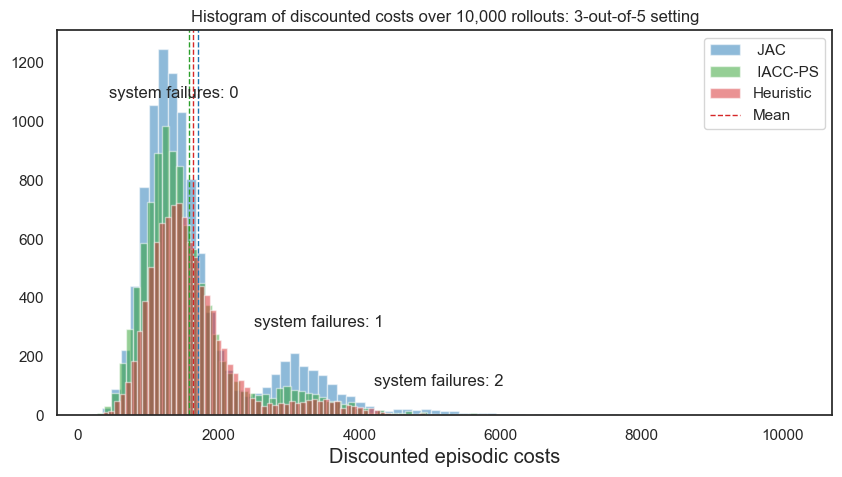

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.set(style='whitegrid')

bins = 75
ax.hist(agent_runs_1, bins=bins, alpha=0.5, label=f' {ALGORITHM_LABEL_1}', color='tab:blue')
ax.hist(agent_runs_2, bins=bins, alpha=0.5, label=f' {ALGORITHM_LABEL_2}', color='tab:green')
ax.hist(FR_costs, bins=bins, alpha=0.5, label='Heuristic', color='tab:red')

# add vertical line for mean and shaded area for std error
ax.axvline(np.mean(agent_runs_1), color='tab:blue', linestyle='dashed', linewidth=1)
ax.axvline(np.mean(agent_runs_2), color='tab:green', linestyle='dashed', linewidth=1)
ax.axvline(np.mean(FR_costs), color='tab:red', linestyle='dashed', linewidth=1, label='Mean')

k = env_setting.split("-")[1]
ax.set_title(f'Histogram of discounted costs over 10,000 rollouts: {k}-out-of-5 setting')
ax.set_xlabel('Discounted episodic costs')

ax.text(450, 1080, 'system failures: 0')
ax.text(2500,300, 'system failures: 1')
ax.text(4200, 100, 'system failures: 2')

plt.legend()
plt.grid(False)

# plt.savefig(f'./histogram-{env_setting}-{ALGORITHM_1}-{ALGORITHM_2}.pdf', dpi=300)

plt.show()